### Loading the dataset

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import pandas as pd
import pickle

In [2]:
listings = pd.read_csv("../data/listings.csv")
reviews = pd.read_csv("../data/reviews.csv")
reviews['comments'] = reviews['comments'].astype(str)

C:\Users\ferna\Anaconda3\envs\cognitivoai\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (61,62,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


##### Number of reviews per year

In [3]:
reviews.date.astype(str).str[0:4].value_counts().sort_index()

2010        35
2011       364
2012      1952
2013      5079
2014     11438
2015     20735
2016     41828
2017     54368
2018     69438
2019    110819
Name: date, dtype: int64

##### Remove null and empty reviews

In [4]:
reviews = reviews[reviews.comments.notnull()]

##### Filter only Portuguese reviews: detect language using langdetect package

In [5]:
from langdetect import detect

def detect_ex(text):
    try:
        return detect(text)
    except:
        return "unknown"
    
#reviews['language'] = reviews['comments'].apply(detect_ex)
#reviews.to_csv("../data/reviews_with_language.csv")

In [6]:
reviews = pd.read_csv("../data/reviews_with_language.csv")

In [7]:
pt_reviews = reviews[reviews['language'] == 'pt']

In [8]:
pt_reviews.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments,language
18,18,17878,597736,2011-10-04,989464,Jose Mauro,Muito Melhor do que ir para um hotel. Apt com ...,pt
19,19,17878,620065,2011-10-11,1157847,Gabriel,"Muito bom o apartamento, a pouco mais de uma q...",pt
33,33,17878,1566424,2012-06-26,2253138,Sergio,"o apartamento é muito confortável, e todo equi...",pt
49,49,17878,3451132,2013-02-01,4142117,Laura,O apartamento é muito bom. Quartos e sala gran...,pt
70,70,17878,5100450,2013-06-12,5538405,Jose Bertoldo,"Bom apartamento, limpo, boa localização, porta...",pt


#### Filtering reviews

* Filter some more reviews with english words
* Remove reviews with less than 10 words

In [9]:
pt_reviews = pt_reviews.drop_duplicates(subset="comments")

In [10]:
en_words = ["great", "small", "very", "amazing"]

In [11]:
### Removing some comments still with english words
for w in en_words:
    pt_reviews = pt_reviews[~pt_reviews.comments.str.contains(w)]

In [13]:
pt_reviews = pt_reviews[~pt_reviews.comments.str.split(" ").str.len() < 10]

In [14]:
pt_reviews.shape

(153735, 8)

##### Selecting a subset of 100k reviews (for reducing computing time)

In [15]:
freviews = pt_reviews.sample(n=100000, random_state=100)

In [16]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stop_words_pt = stopwords.words('portuguese')

#### Testing different pre-processing steps

* Stemming, lemmatization, normalization (lowercase and remove accents)

In [18]:
##### Reviews preprocessing

import gensim
import unicodedata
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models import CoherenceModel
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
np.random.seed(42)

stemmer = SnowballStemmer('portuguese')

def strip_accents(text):

    try:
        text = unicode(text, 'utf-8')
    except NameError: # unicode is a default on python 3 
        pass

    text = unicodedata.normalize('NFD', text)\
           .encode('ascii', 'ignore')\
           .decode("utf-8")

    return str(text)

def lemmatize_stemming(text):
    #return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
    #return WordNetLemmatizer().lemmatize(text, pos='v')
    #return stemmer.stem(strip_accents(text).lower())
    return strip_accents(text).lower()

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        #if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) >= 3:
        if token not in stop_words_pt and len(token) >= 3:
            result.append(lemmatize_stemming(token))
    return result

C:\Users\ferna\Anaconda3\envs\cognitivoai\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


#### Not using stemming nor lemmatizers, only removing accents and converting all strings to lowercase

In [19]:
original_reviews = freviews['comments'].reset_index(drop=True)
processed_reviews = original_reviews.map(preprocess)

In [20]:
processed_reviews.shape

(100000,)

#### Dataset as Bag of Words (BoW)

* Vocabulary max size: 100000 tokens
* Remove tokens that appear in less than 15 reviews

In [21]:
dictionary = gensim.corpora.Dictionary(processed_reviews)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_reviews]

In [26]:
def debug_review(i):
    print("Original: ")
    print(freviews['comments'].values[i])
    print()
    print("Preprocessed: ")
    print(",".join(processed_reviews.values[i]))
    print()
    print("Bow: ")
    print(",".join([dictionary[word[0]] for word in bow_corpus[i]]))
    
debug_review(i=14002)

Original: 
A casa é exatamente como está nas fotos. Muito bem localizada, perto de supermercado, farmácia e bares. Patrick foi sempre atencioso quando solicitado.

Preprocessed: 
casa,exatamente,fotos,bem,localizada,perto,supermercado,farmacia,bares,patrick,sempre,atencioso,solicitado

Bow: 
sempre,bem,perto,casa,farmacia,supermercado,atencioso,localizada,bares,fotos,exatamente,solicitado,patrick


#### Running LDA with BoW corpus

* Another option would be to prepare the corpus using a TF-IDF approach.

In [27]:
import warnings
warnings.filterwarnings("ignore")

##### Checking Coherence for  different number of topics

In [28]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [29]:
start=2; limit=16; step=2
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=bow_corpus, texts=processed_reviews, start=start, limit=limit, step=step)

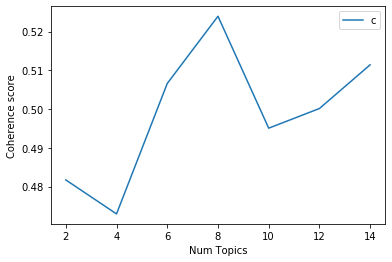

In [33]:
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [34]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=bow_corpus,
                                           id2word=dictionary,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=2000,
                                           passes=20,
                                           alpha='symmetric',
                                           iterations=50,
                                           per_word_topics=True)

Wall time: 28min 10s


In [38]:
pickle.dump(lda_model, open( "lda_model_full_bow_8_topis_20_passes.pkl", "wb" ))

##### LDA Validation

In [35]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(bow_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_reviews, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.770910271811149

Coherence Score:  0.5227872957462049


### LDA Visualization

In [125]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from wordcloud import WordCloud, STOPWORDS
import itertools
from nltk.corpus import stopwords

%matplotlib inline

### Insights observed:

* Topic 1: elogiando o anfitrião, host (aparenetmente anfitrião masculino)
* Topic 2: elogiando o apto
* Topic 3: sobre a experiência no rio de janeiro, da viagem, momentos
* Topic 4: elogiando o anfitrião (aparentemente anfitriã feminina)
* Topic 5: elogios em geral, não ficou claro
* Topic 6: proximidade, localização, acesso facil, andar a pé, transporte publico, locomoção, uber, metro, bairro
* Topic 7: comentários sobre os aposentos, detalhes do apto, parecem ser reclamações
* Topic 8: localização também, porém com relação à proximidade de comodidades como restaurantes, mercados, padarias, bancos, lanchonetes, farmacias..



### Insights observed:

* **Topic 1:** positive recommendations about the host, the host is a men (male adjectives)
* **Topic 2:** positive recommendations about the apartment (the view, cleaness, cost benefit, "it is worth")
* **Topic 3:** positive comments about the experience in Rio de Janeiro, the trip, the moments and experiences lived in this trip
* **Topic 4:** positive recommendations about the host, the host is a men (female adjectives)
* **Topic 5:** general good recommendations (including the host, the apartment, the location, etc..)
* **Topic 6:** comments about the location mainly, how it is close to everything, easy access, walking distance, public transportation, metro, uber, etc..
* **Topic 7:** comments especifically about the furniture of the apartment and it seems to be mainly complaints about AC, the kitchen, the bed, towerls, water, internet, etc.. 
* **Topic 8:** comments about location as well, but mainly describing the facilities nearby and the proximity to restaurants, grocery stores, banks, pharmacies,bakeries, etc.. 

In [40]:
import pyLDAvis
import pyLDAvis.gensim

In [84]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, bow_corpus, dictionary, sort_topics=False)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.186496  0.037428       1        1   9.950517
1     -0.199711 -0.011399       2        1  10.327724
2      0.175730  0.263899       3        1  12.621251
3     -0.086990  0.166094       4        1  13.133688
4     -0.171701 -0.057045       5        1  15.688340
5      0.283286 -0.170520       6        1  11.786588
6      0.233289  0.001633       7        1  13.128437
7     -0.047406 -0.230089       8        1  13.363452, topic_info=    Category          Freq         Term         Total  loglift  logprob
20   Default  57178.000000          bem  57178.000000  30.0000  30.0000
35   Default  37811.000000  localizacao  37811.000000  29.0000  29.0000
121  Default  18165.000000        praia  18165.000000  28.0000  28.0000
145  Default  19183.000000   localizado  19183.000000  27.0000  27.0000
162  Default  10489.000000    anfitriao  10489.000000  26.0000  26.0000
..       ...           ...          ...           ...      ...      ...
10    Topic8   3258.216309        otima  24700.820312  -0.0130  -4.4555
145   Topic8   2676.182617   localizado  19183.738281   0.0430  -4.6523
7     Topic8   2510.550049        limpo  21152.777344  -0.1186  -4.7161
621   Topic8   2041.407349        fotos   8871.252930   0.5435  -4.9230
150   Topic8   2109.257324        super  33931.292969  -0.7654  -4.8903

[518 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
396       6  0.999702       acesso
580       4  0.997988   acolhedora
1031      5  0.991975  acolhimento
864       1  0.123011   acomodacao
864       2  0.581378   acomodacao
...     ...       ...          ...
1171      4  0.958653          vou
1171      7  0.040857          vou
349       8  0.999811      website
539       7  0.998254         wifi
333       6  0.998567         zona

[833 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5, 6, 7, 8])

##### Select main topic for each review (topic with highest percentage)

In [153]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num)+1, round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus, texts=original_reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,4.0,0.5439,"super, casa, tudo, voltar, atenciosa, anfitria...","A estadia foi ótima! O apto muito bonito, limp..."
1,1,3.0,0.3734,"rio, melhor, casa, experiencia, dias, desde, v...",Passamos alguns dias no Rio e ficamos muito en...
2,2,3.0,0.3793,"rio, melhor, casa, experiencia, dias, desde, v...",Retornamos ao apartamento do Leandro um mês ap...
3,3,3.0,0.5761,"rio, melhor, casa, experiencia, dias, desde, v...",Maravilhoso é pouco. Posso literalmente descre...
4,4,5.0,0.4073,"bem, apartamento, localizado, limpo, super, re...","Karine é super hospitaleira, dedicada, atencio..."


##### Main review for each topic (best example review of a topic)

In [128]:
sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
display(sent_topics_sorteddf_mallet.head(8))
for t in sent_topics_sorteddf_mallet.head(8)['Representative Text'].values:
    print(t)
    print("")

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,1.0,0.9635,"anfitriao, atencioso, apartamento, sempre, loc...",O apto é realmente tudo igual o que está na fo...
1,2.0,0.9514,"localizacao, excelente, otima, apartamento, vi...","O apartamento é excelente! Um ótimo espaço, tu..."
2,3.0,0.9485,"rio, melhor, casa, experiencia, dias, desde, v...",Foi minha primeira experiência e a melhor de t...
3,4.0,0.9687,"super, casa, tudo, voltar, atenciosa, anfitria...","Hospitalidade maravilhosa, a Gilma é extremame..."
4,5.0,0.9583,"bem, apartamento, localizado, limpo, super, re...","Adoramos o apartamento! Super lindo, amplo, mu..."
5,6.0,0.9271,"facil, acesso, fica, bem, proximo, rio, pra, p...","O lugar e de fácil acesso, muito tranquilo, mu..."
6,7.0,0.9708,"cama, apartamento, cozinha, condicionado, quar...","O apartamento é bom, mas tive problemas durant..."
7,8.0,0.9619,"praia, apartamento, perto, restaurantes, proxi...",Nossa estadia no apartamento da Noele foi sens...


O apto é realmente tudo igual o que está na foto e na descrição. Localização excelente. Além disso o Rafael foi super atencioso e estava sempre a disposição quando eu precisava de alguma informação. Tanto indico quanto retornarei quando puder. 

O apartamento é excelente! Um ótimo espaço, tudo muito limpo, excelente condomínio. A localização é muito boa! Recomendo fortemente o lugar para quem deseja curtir a Barra da Tijuca!

Foi minha primeira experiência e a melhor de todas. Não tenho palavras para descrever essa experiência. Melhor hospedagem da vida. Muito melhor que muito hotel 5 estrelas por aí. Agradeço muito pela hospedagem incrível!

Hospitalidade maravilhosa, a Gilma é extremamente atenciosa, generosa, sempre disposta a ajudar, tirar dúvidas, te dar uma carona amiga e um café da manha maravilhoso. Sua casa é otima, super limpa, organizada.. Foi uma experiência incrível, com certeza voltarei. Recomendo!!!

Adoramos o apartamento! Super lindo, amplo, muito bem mobiliado, com to

##### Frequency of words per topic

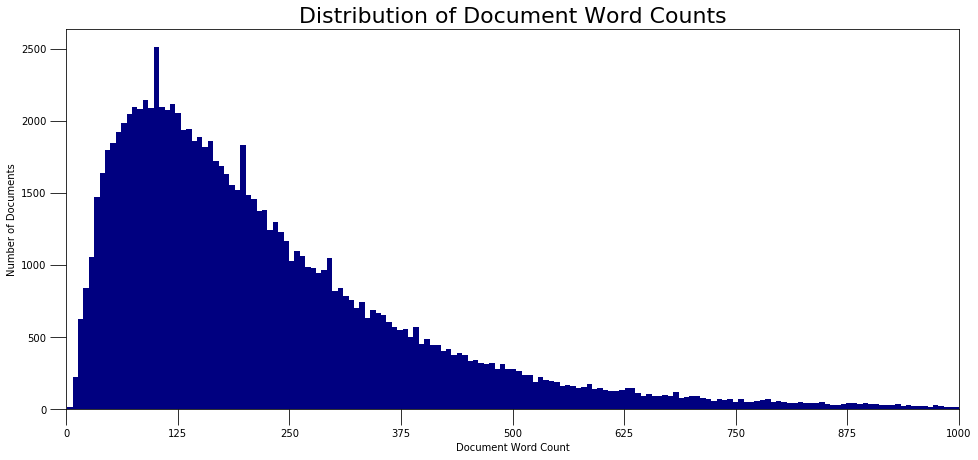

In [129]:
doc_lens = [len(d) for d in df_dominant_topic.Text.astype(str)]

# Plot
plt.figure(figsize=(16,7))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

In [150]:
doc_lens = [len(d) for d in df_dominant_topic.Text.astype(str)]
pd.Series(doc_lens).describe()

count    100000.000000
mean        233.487490
std         210.348645
min           1.000000
25%         101.000000
50%         179.000000
75%         300.000000
max        6063.000000
dtype: float64

### Insights Observed:

* Topics 1 2 and 5, which are usually good and positive reviews about the host and the apartment are usually smaller reviews
* Topic 7, which are usually complaints about the apartment and furniture tends to be longer reviews, which makes sense, so they can explain what was the problem
* Topic 6 and 8, talking mainly about location, also tends to be longer, following a smoother distribution

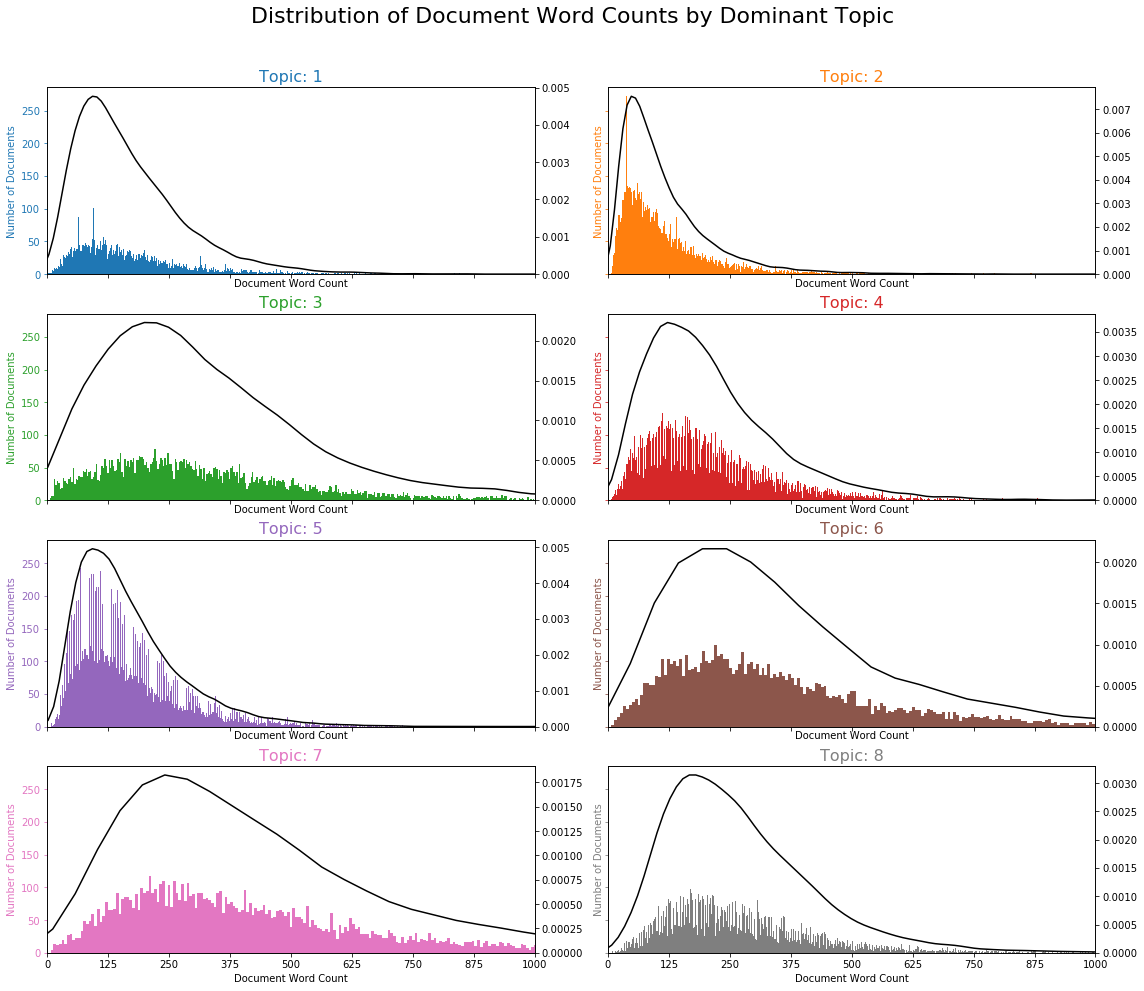

In [146]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i+1, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i+1), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

##### Word cloud per topic (original review)

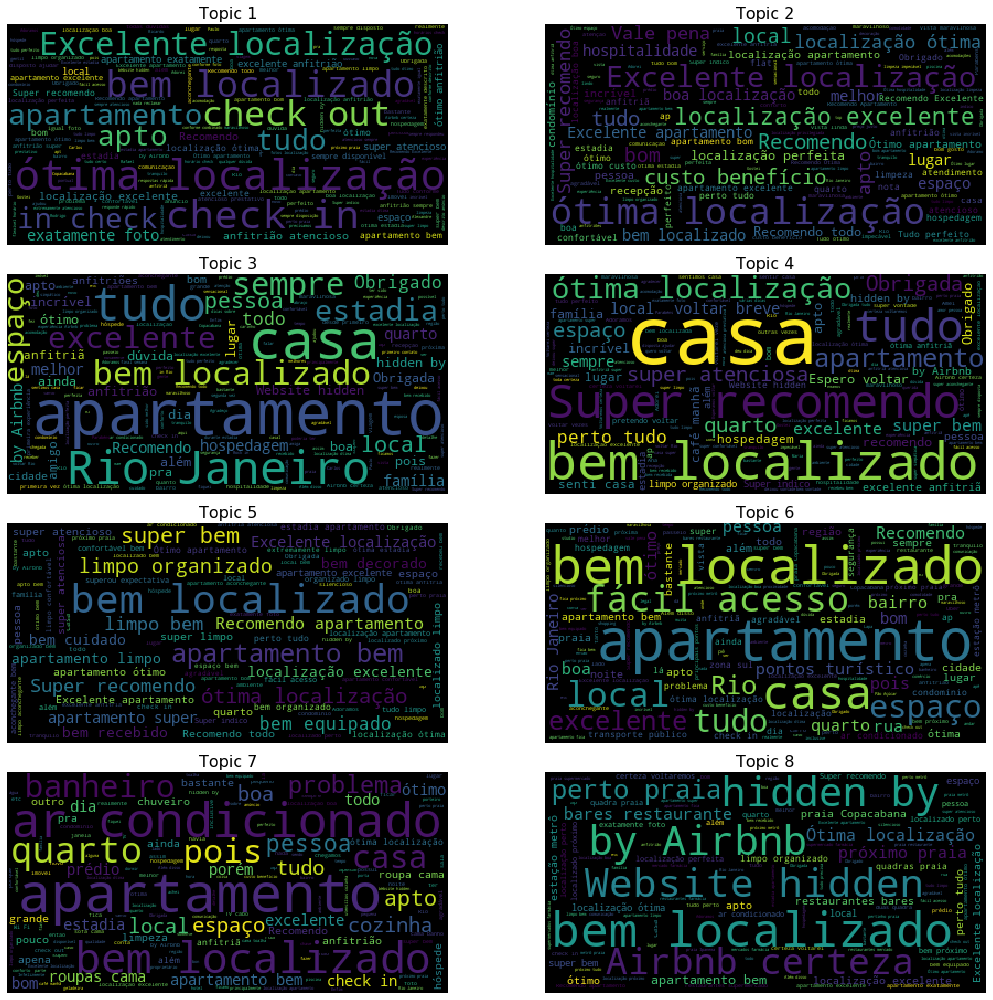

In [136]:
# 1. Wordcloud of Top N words in each topic

stop_words = stopwords.words('portuguese')

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  max_words=200,
                  normalize_plurals=True)

fig, axes = plt.subplots(4, 2, figsize=(16,14), sharex=True, sharey=True)

for clust, ax in zip(sorted(df_dominant_topic['Dominant_Topic'].unique()), axes.flatten()):
    df_cat = df_dominant_topic.loc[df_dominant_topic['Dominant_Topic']==clust]['Text']
    text = ' '.join(list(itertools.chain(df_cat)))                       
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate(text)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(int(clust)), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##### Word cloud per topic (main words)

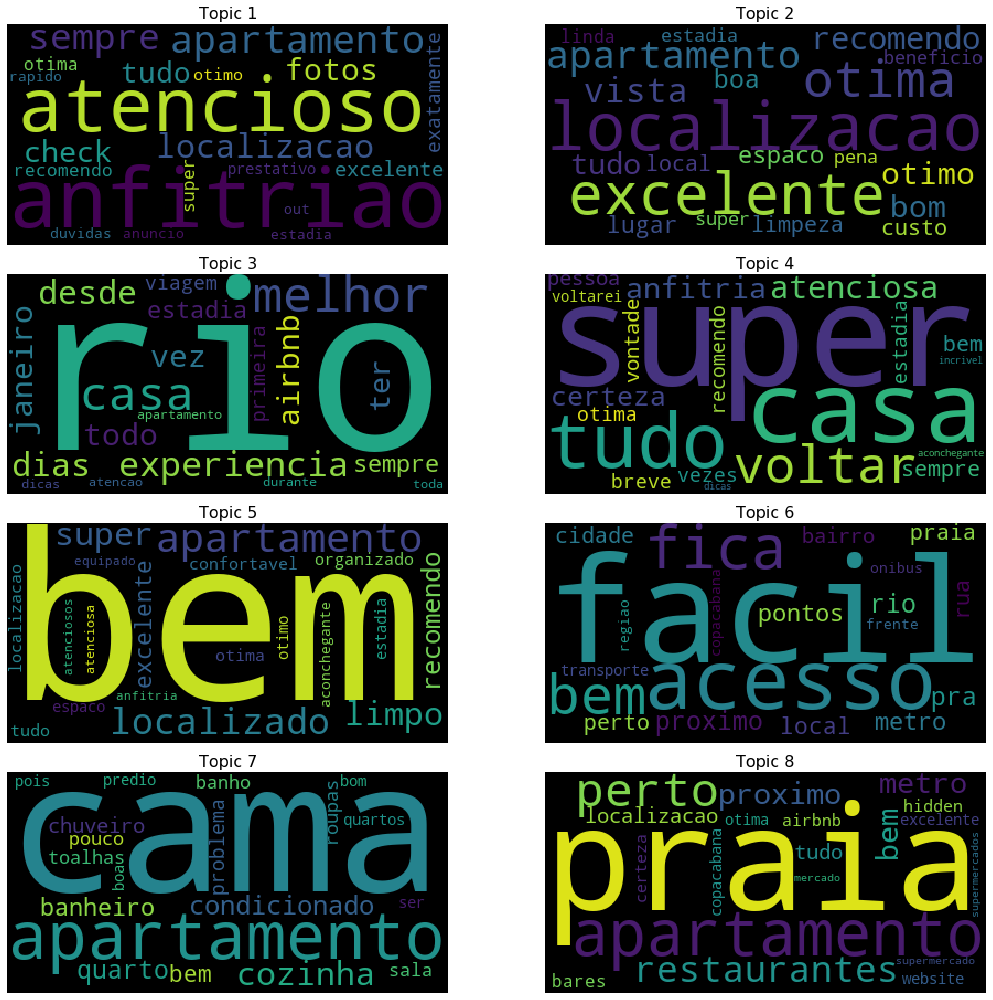

In [133]:
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  normalize_plurals=True,
                  max_words=200)

topics = lda_model.show_topics(formatted=False, num_words=20)

fig, axes = plt.subplots(4, 2, figsize=(16,14), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i+1), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

##### Word Counts for each topic keyword

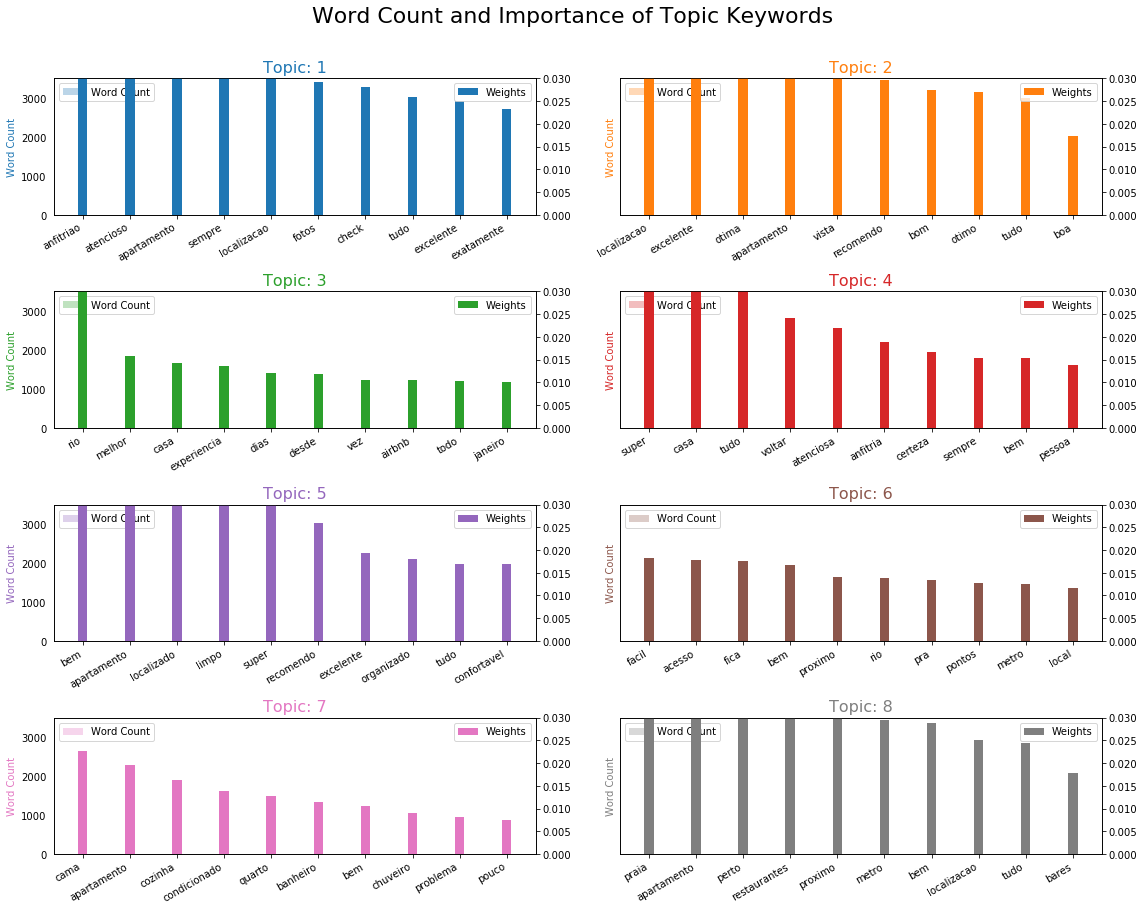

In [134]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in original_reviews for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(4, 2, figsize=(16,12), sharey=True)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.3, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i+1), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

## Clustering reviews by its distribution of topics with K-Means

In [142]:
def get_document_distributions(corpus):
    distributions = []
    for rev in lda_model.get_document_topics(corpus, minimum_probability=0.0):
        distributions.append({c:p for c, p in rev})
    return pd.DataFrame(distributions)        

dist_df = get_document_distributions(bow_corpus)

100%|██████████████████████████████████████████████████████████████████████████████| 10/10 [8:57:23<00:00, 3224.35s/it]


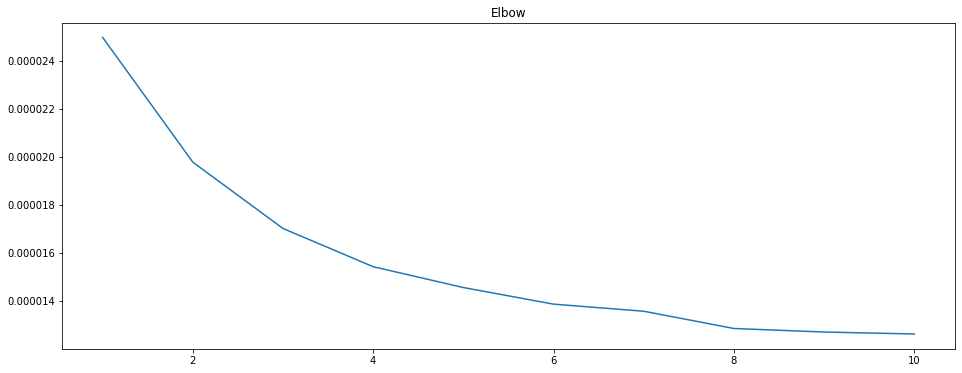

In [143]:
from nltk.cluster.kmeans import KMeansClusterer
from tqdm import tqdm
import nltk
import numpy as np
import random
random.seed(42)

square_errors = []
for k in tqdm(range(1,11)):
    kclusterer = KMeansClusterer(num_means=k,
                                 distance=nltk.cluster.util.cosine_distance,
                                 #distance=nltk.cluster.util.euclidean_distance,
                                 repeats=1,
                                 rng=random
                                 )
#     kclusterer = KMeansClusterer(num_means=k,
#                                  distance=nltk.cluster.util.euclidean_distance,
#                                  repeats=1)
    assigned_clusters = kclusterer.cluster(dist_df.values, assign_clusters=True)

    sum_of_squares = 0
    current_cluster = 0
    for centroid in kclusterer.means():
        current_page = 0
        for index_of_cluster_of_page in assigned_clusters:
            if index_of_cluster_of_page == current_cluster:
                y = dist_df.values[current_page]
                #sum_of_squares += np.sum((centroid - y) ** 2)
                sum_of_squares += (np.dot(centroid,y)**2)/(np.dot(centroid,centroid) * np.dot(y,y))
            current_page += 1
        current_cluster += 1

    square_errors.append(sum_of_squares)

plt.figure(figsize=(16,6))
plt.plot(range(1,11), 1/np.array(square_errors))
plt.title('Elbow')
plt.show()

#### Zooming in to find a peak for the best K

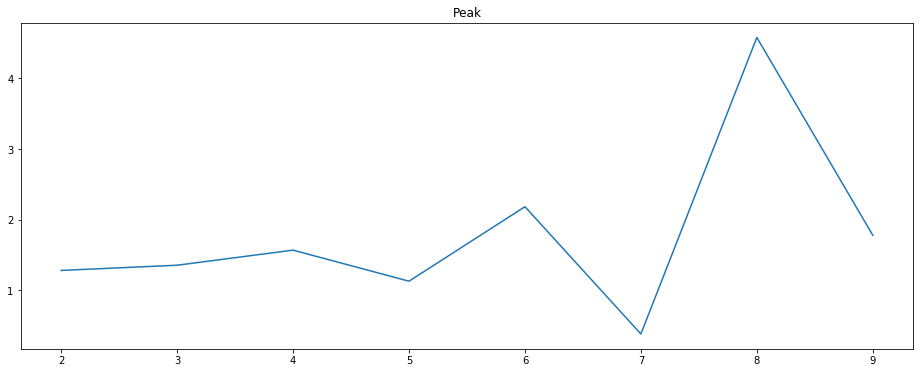

In [144]:
new = [np.abs((square_errors[i-1] - square_errors[i])/(square_errors[i] - square_errors[i+1])) for i in range(1, len(square_errors)-1)]
plt.figure(figsize=(16,6))
plt.plot(range(2,10), new)
plt.title('Peak')
plt.show()

### Insights Observed

* When plotting the Elbow curve for a K-means clustering, we see, indeed that the best K is 8, which enforces the choise for 8 topics. That means, evens considering the distribution of topics for each document, we still can find a good separation between these 8 different groups of comments

#### Cluster with k=8

In [156]:
import nltk
from nltk.cluster.kmeans import KMeansClusterer
import random
random.seed(42)
kclusterer = KMeansClusterer(num_means=8,
                             distance=nltk.cluster.util.cosine_distance,
                             #distance=nltk.cluster.util.euclidean_distance,
                             repeats=10,
                             rng=random)
# kclusterer = KMeansClusterer(num_means=5,
#                              distance=nltk.cluster.util.euclidean_distance,
#                              repeats=1)
assigned_clusters = kclusterer.cluster(dist_df.values,
                                       assign_clusters=True)
df_dominant_topic['assigned_clusters'] = assigned_clusters

In [158]:
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,assigned_clusters
0,0,4.0,0.5439,"super, casa, tudo, voltar, atenciosa, anfitria...","A estadia foi ótima! O apto muito bonito, limp...",5
1,1,3.0,0.3734,"rio, melhor, casa, experiencia, dias, desde, v...",Passamos alguns dias no Rio e ficamos muito en...,1
2,2,3.0,0.3793,"rio, melhor, casa, experiencia, dias, desde, v...",Retornamos ao apartamento do Leandro um mês ap...,1
3,3,3.0,0.5761,"rio, melhor, casa, experiencia, dias, desde, v...",Maravilhoso é pouco. Posso literalmente descre...,1
4,4,5.0,0.4073,"bem, apartamento, localizado, limpo, super, re...","Karine é super hospitaleira, dedicada, atencio...",2


### Word cloud for KMeans clusters

0


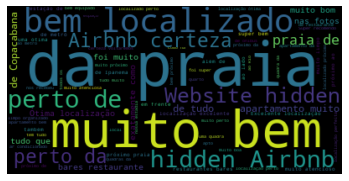

1


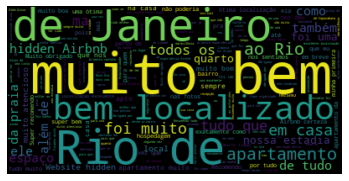

2


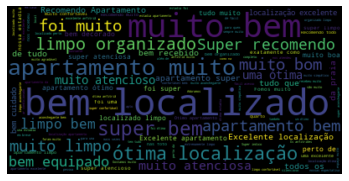

3


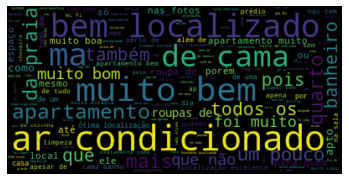

4


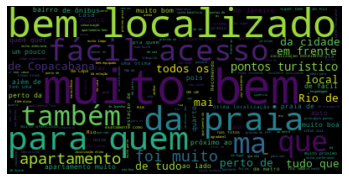

5


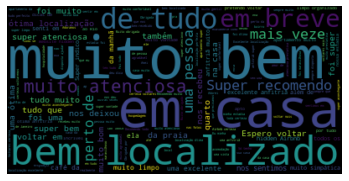

6


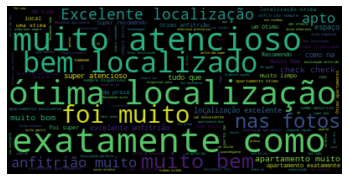

7


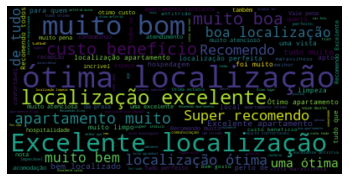

In [159]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import itertools

wordcloud = WordCloud(max_words=200,
                      normalize_plurals=True)

for clust in sorted(df_dominant_topic['assigned_clusters'].unique()):
    print(clust)
    df_cat = df_dominant_topic.loc[df_dominant_topic['assigned_clusters']==clust]['Text']
    text = ' '.join(list(itertools.chain(df_cat)))

    plt.imshow(wordcloud.generate(text), interpolation='bilinear')
    plt.axis("off")
    plt.show()